In [40]:
function reload(name)
    package.loaded[name] = nil
    return require(name)
end

image = require 'image'
require 'nn'
require 'os'
require 'paths'
require 'optim'
require 'sys'

logger = optim.Logger('./logs/loss_log.txt')

os.execute('mkdir -p dataset logs models')

reload('utils')

In [17]:

labels_train, labels_validation, data_train, data_validation = utils.load_data()


file exists	


In [21]:

model = nn.Sequential()
model:add(nn.SpatialConvolution(3,16,3,3,1,1,1,1))
model:add(nn.LeakyReLU(0.2))
model:add(nn.SpatialFullConvolution(16, 3, 2, 2, 2, 2, 0, 0, 0, 0))
model:add(nn.LeakyReLU(0.2))
model:add(nn.View(3*102*102))
model:add(nn.Tanh())

params_1 = {
    sgd_params = sgd_params,
    model = model,
    criterion = criterion,
    data_train = data_train,
    labels_train = labels_train,

    num_of_epochs = 5,
    batch_size = 20,
    model_name = 'srcnn_test_2'
}

utils.start_training(params_1)


epoch	duration	loss	


1	4s	0.82413550606057	


2	4s	0.56393823799589	


3	4s	0.39333910788821	


4	4s	0.29388149485736	


5	3s	0.23609195702881	


model saved	


losses saved	


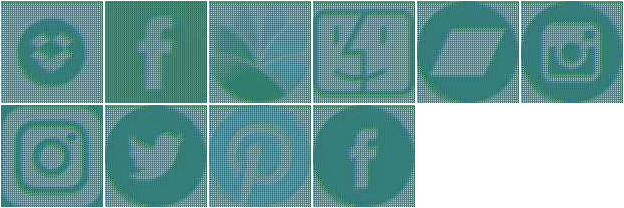

In [88]:

images = torch.Tensor(10,3,102,102)
for i=1,10 do
    imagefile = "./results/srcnn_test/images/img_" ..i..".jpg"
    img = image.load(imagefile,3,'double')
--     itorch.image(img)
    images[i] = img
end


 itorch.image(images)
-- print(images:size())

-- torch.save('./dataset/images.t7', images)

In [85]:

-- labels_train:size()
-- r = models.model_9_5_5:forward(labels_train[{1}])

o1 = data_train[{{1,2}}]
print(o1:size())
m1 = nn.SpatialConvolution(3,64,9,9,1,1,4,4)

o2 = m1:forward(o1)
print(o2:size())
m2 = nn.SpatialConvolution(64,32,5,5,1,1,2,2)

o3 = m2:forward(o2)
print(o3:size())
m3 = nn.SpatialFullConvolution(32,3,6,6,2,2,2,2)

o4 = m3:forward(o3)
print(o4:size())


  2
  3
 51
 51
[torch.LongStorage of size 4]



  2
 64
 51
 51
[torch.LongStorage of size 4]



  2
 32
 51
 51
[torch.LongStorage of size 4]



   2
   3
 102
 102
[torch.LongStorage of size 4]

